In [34]:
import glacierml
import tensorflow as tf

In [35]:
print(tf.__version__)

2.8.0


# Step 0. Match the indices in RGI with those in GlaThiDa
This corresponds to the file ```workflow_step0_merge_training_data.py```. But note that this is can't really be run in a notebook because with ```useMP=True``` then note that multiprocessing doesn't play well with notebooks...

In [36]:
pth = '/data/fast1/glacierml/data/'
# output=glacierml.match_GlaThiDa_RGI_index(pth=pth, useMP=True);
# This writes the file to:  pth + '/v2/GlaThiDa_with_RGIId_v2.csv'

# Step 1. Build and train models.
This corresponds to the file ```workflow_step1_run_bootstrap_and_ensemble.py```.
Here, to illustrate the general ideas, we just build and train a single model rather than
going through the bootstrap/ensemble process.

First, load the training data,

In [69]:
dataset = glacierml.parameterize_data(parameterization = '3')
# parameterization, dataset, dataset.name, res = \
#     glacierml.select_dataset_coregistration(pth=pth)
dataset

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness
0,63.469173,-146.528168,12.0,722,1841,3081,234.583,30,41911,235.0
1,63.281000,-145.427000,14.0,1162,1858,2438,17.567,172,8639,147.0
2,58.380000,-134.349000,10.0,676,1123,1494,9.528,327,6332,66.0
8,61.200000,-140.302000,14.0,2145,2509,2894,5.859,341,3374,66.0
9,51.177000,-116.330000,15.3,2390,2526,2853,0.872,69,1181,70.0
...,...,...,...,...,...,...,...,...,...,...
489,-33.029600,-70.098400,29.0,2929,5121,5894,8.376,358,8560,59.0
490,-30.145400,-69.927600,29.3,4664,5187,5525,1.189,148,1596,28.0
491,-28.538700,-69.731800,16.0,4784,5234,5597,3.140,190,3349,39.0
492,-28.381400,-69.609100,11.6,5068,5406,5753,5.209,79,3782,67.0


In [70]:
# dataset = dataset.drop('Zmed', axis = 1)

In [71]:
# import numpy as np
# dataset['Area'] = dataset['Area'] * 1e6
# dataset['Area'] = np.log(dataset['Area'])
# dataset['Lmax'] = np.log(dataset['Lmax'])

Then train a single NN model with the data:

In [72]:
# lr_input = 0.01
rs = 0
# ep_input = 2000
layer_1_input = 15
layer_2_input = 12
dropout = True
parameterization = '5'
dnn_model = glacierml.build_and_train_model(
                        dataset, 
#                         learning_rate = float(lr_input), 
#                         random_state = rs, 
#                         epochs = int(ep_input), 
                        parameterization = parameterization, 
#                         res = res,
                        layer_1 = layer_1_input,
                        layer_2 = layer_2_input,
                        dropout = dropout,
                        writeToFile = False
)   

In [73]:
model_thicknesses = glacierml.evaluate_model('10-5', rs, dataset, dnn_model, parameterization)
model_thicknesses

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,model,test mae,train mae,layer architecture,parameterization,total parameters,GlaThiDa Thickness,E&L Thickness,Residual
0,78.128100,15.626700,12.8,332,583,970,3.463,351,4254,0,20.698681,15.451345,10-5,5,374,67.0,65.359184,1.640816
1,49.854897,87.375351,33.0,2716,2935,3192,0.542,11,704,0,20.698681,15.451345,10-5,5,374,48.0,41.726688,6.273312
2,78.040900,13.953500,15.1,194,319,423,1.137,35,1964,0,20.698681,15.451345,10-5,5,374,62.0,59.213306,2.786694
3,41.414010,-122.211330,21.5,3033,3492,4180,1.291,332,3168,0,20.698681,15.451345,10-5,5,374,20.0,27.652872,-7.652872
4,47.099100,12.696700,15.9,2086,2984,3487,17.774,112,8667,0,20.698681,15.451345,10-5,5,374,67.0,65.807175,1.192825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,28.470000,85.816000,9.2,5710,5866,5944,1.327,30,1244,0,20.698681,15.451345,10-5,5,374,47.0,75.774651,-28.774651
337,-41.111000,-72.498700,32.6,1589,2067,2653,2.555,189,1713,0,20.698681,15.451345,10-5,5,374,17.0,23.350767,-6.350767
338,-39.426700,-71.912200,11.1,1584,2000,2835,13.098,83,5447,0,20.698681,15.451345,10-5,5,374,47.0,79.979080,-32.979080
339,-38.983000,-71.531700,5.9,1833,2098,2265,5.273,232,3177,0,20.698681,15.451345,10-5,5,374,324.0,75.908836,248.091164


In [74]:
model_thicknesses['Residual'].mean()

2.207233686251375

Text(0, 0.5, 'E&L Thickness')

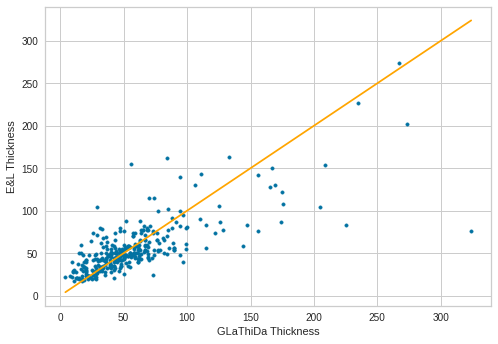

In [75]:
import matplotlib.pyplot as plt
plt.scatter(model_thicknesses['GlaThiDa Thickness'], model_thicknesses['E&L Thickness'],
           marker = '.')
plt.plot(
    (model_thicknesses['GlaThiDa Thickness'].min(),
    model_thicknesses['GlaThiDa Thickness'].max()),
    (model_thicknesses['GlaThiDa Thickness'].min(),
    model_thicknesses['GlaThiDa Thickness'].max()),
    color = 'orange'
)
plt.xlabel('GLaThiDa Thickness')
plt.ylabel('E&L Thickness')

In [44]:
model_statistics = glacierml.calculate_model_avg_statistics(
            dnn_model,
            '10-5',
            dataset,
            model_thicknesses
        )
model_statistics

,layer architecture,total parameters,trained parameters,total inputs,test mae avg,train mae avg,test mae std dev,train mae std dev
0,10-5,374.0,355.0,3060.0,16.846884,15.572668,0.0,0.0


In [45]:
RGI = glacierml.load_RGI()
# RGI = RGI.drop(['RGIId', 'region'], axis = 1)
RGI

,RGIId,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,region
0,RGI60-01.00001,63.6890,-146.8230,42.0,1936,2385,2725,0.360,346,839,01
1,RGI60-01.00002,63.4040,-146.6680,16.0,1713,2005,2144,0.558,162,1197,01
2,RGI60-01.00003,63.3760,-146.0800,18.0,1609,1868,2182,1.685,175,2106,01
3,RGI60-01.00004,63.3810,-146.1200,19.0,1273,1944,2317,3.681,195,4175,01
4,RGI60-01.00005,63.5510,-147.0570,16.0,1494,1914,2317,2.573,181,2981,01
...,...,...,...,...,...,...,...,...,...,...,...
216496,RGI60-19.02748,-53.9860,-37.7325,29.9,310,-999,510,0.042,315,255,19
216497,RGI60-19.02749,-54.8310,-36.1361,23.6,330,-999,830,0.567,200,1130,19
216498,RGI60-19.02750,-54.1884,-37.3018,16.8,10,-999,1110,4.118,308,4329,19
216499,RGI60-19.02751,-68.8656,-90.4266,0.4,170,-999,270,0.011,122,106,19


In [46]:
# RGI['region'] = RGI['RGIId'].str[6:8]
for region_selection in range(1,20,1):
#     print(region_selection)
    
    
    
    if len(str(region_selection)) == 1:
        N = 1
        region_selection = str(region_selection).zfill(N + len(str(region_selection)))
    else:
        region_selection = region_selection

    
    RGI = RGI.reset_index()
    RGI = RGI.drop('index', axis=1)
#     if region_selection != '19':
    drops = RGI[
        ((RGI['region'] == str(region_selection)) & (RGI['Zmin'] < 0)) |
        ((RGI['region'] == str(region_selection)) & (RGI['Zmed'] < 0)) |
        ((RGI['region'] == str(region_selection)) & (RGI['Zmax'] < 0)) |
        ((RGI['region'] == str(region_selection)) & (RGI['Slope'] < 0)) |
        ((RGI['region'] == str(region_selection)) & (RGI['Aspect'] < 0))
    ].index
#         print(drops)
#         if not drops.empty:
#             print('dropping bad data')
    RGI = RGI.drop(drops)
RGI

,RGIId,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,region
0,RGI60-01.00001,63.6890,-146.823,42.0,1936,2385,2725,0.360,346,839,01
1,RGI60-01.00002,63.4040,-146.668,16.0,1713,2005,2144,0.558,162,1197,01
2,RGI60-01.00003,63.3760,-146.080,18.0,1609,1868,2182,1.685,175,2106,01
3,RGI60-01.00004,63.3810,-146.120,19.0,1273,1944,2317,3.681,195,4175,01
4,RGI60-01.00005,63.5510,-147.057,16.0,1494,1914,2317,2.573,181,2981,01
...,...,...,...,...,...,...,...,...,...,...,...
213702,RGI60-18.03533,-43.4215,170.354,34.7,1231,1724,2098,0.189,116,944,18
213703,RGI60-18.03534,-43.4550,170.349,36.1,1881,2106,2208,0.040,108,331,18
213704,RGI60-18.03535,-43.4400,170.351,39.2,1677,1974,2253,0.184,104,740,18
213705,RGI60-18.03536,-43.4106,170.364,34.0,1627,1839,1928,0.111,135,406,18


In [47]:
RGI = RGI.drop(['RGIId', 'region'], axis = 1)

In [48]:
RGI

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax
0,63.6890,-146.823,42.0,1936,2385,2725,0.360,346,839
1,63.4040,-146.668,16.0,1713,2005,2144,0.558,162,1197
2,63.3760,-146.080,18.0,1609,1868,2182,1.685,175,2106
3,63.3810,-146.120,19.0,1273,1944,2317,3.681,195,4175
4,63.5510,-147.057,16.0,1494,1914,2317,2.573,181,2981
...,...,...,...,...,...,...,...,...,...
213702,-43.4215,170.354,34.7,1231,1724,2098,0.189,116,944
213703,-43.4550,170.349,36.1,1881,2106,2208,0.040,108,331
213704,-43.4400,170.351,39.2,1677,1974,2253,0.184,104,740
213705,-43.4106,170.364,34.0,1627,1839,1928,0.111,135,406


In [49]:
predictions = dnn_model.predict(RGI, verbose = 0)
predictions

array([[14.059942],
       [51.90495 ],
       [61.644817],
       ...,
       [56.042747],
       [57.702953],
       [61.650784]], dtype=float32)